# Valorant VCT Predictions

## Backstory
The first file I was able to create a model that can predict with up to 70% accuracy. Since then I learned quite a bit about data analytics and figured it would be easier to start fresh when training my next models.

Goal for this file is to get up to 80% accuracy and I will try to explore different models outside of logistic regression.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('goodData.csv')
data = data[['o_playerACS', 'o_playerADR', 'o_playerAssists',
       'o_playerDeaths', 'o_playerFirstBlood', 'o_playerFirstDeath',
       'o_playerHS', 'o_playerKills', 'o_playerTeam', 'playerACS', 'playerADR',
       'playerAssists', 'playerDeaths', 'playerFirstBlood', 'playerFirstDeath',
       'playerHS', 'playerKills', 'playerTeam']].shift(1)

,o_playerACS,o_playerADR,o_playerAssists,o_playerDeaths,o_playerFirstBlood,o_playerFirstDeath,o_playerHS,o_playerKills,o_playerTeam,playerACS,playerADR,playerAssists,playerDeaths,playerFirstBlood,playerFirstDeath,playerHS,playerKills,playerTeam
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,915.0,583.7,18.3,77.9,8.2,11.2,111.5,60.6,CREA,909.1,578.3,20.0,77.7,7.2,11.4,128.7,59.2,ORB
2,1108.4,708.0,33.6,67.0,10.8,10.2,93.2,81.4,V1,654.3,428.1,15.2,41.6,6.7,5.6,63.4,44.2,AE
3,1103.1,707.5,34.5,67.8,11.1,10.0,91.3,81.3,V1,648.2,422.5,14.6,43.2,7.0,6.3,65.9,44.5,AE
4,1014.9,651.1,19.0,57.1,10.8,10.2,138.0,66.5,GHOST,183.9,116.3,7.4,13.8,1.8,1.4,20.5,11.7,FH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651,197.0,122.0,5.1,14.0,0.9,1.3,19.4,14.8,REVI,179.5,104.8,2.9,15.1,2.4,4.0,12.9,12.0,DTG
7652,194.2,120.2,4.7,14.2,1.1,1.5,20.3,14.1,REVI,203.4,115.3,3.1,14.3,2.8,3.8,11.8,13.4,DTG
7653,169.5,107.8,4.7,15.4,2.1,1.9,27.5,12.3,FIRE,1125.6,713.2,25.6,65.5,10.8,8.9,130.8,78.3,AES
7654,174.8,109.2,4.2,15.4,2.3,1.6,28.1,12.7,FIRE,1111.0,703.3,24.7,66.5,10.5,9.3,133.2,77.4,AES


# Graphing
Visually seeing what parameters will be good to include in the model

<AxesSubplot:xlabel='o_playerACS', ylabel='playerACS'>

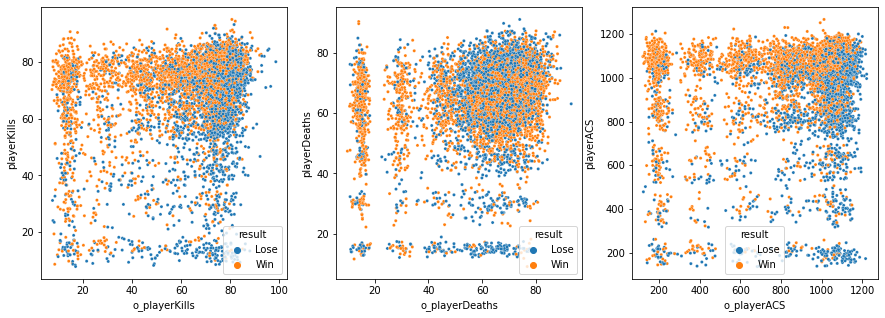

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(data=data, x='o_playerKills', y='playerKills', hue='result', ax=ax1, s=10)
sns.scatterplot(data=data, x='o_playerDeaths', y='playerDeaths', ax=ax2, hue='result', s=10)
sns.scatterplot(data=data, x='o_playerACS', y='playerACS', ax=ax3, hue='result', s=10)

In [32]:
data['kdRatio'] = data.apply(lambda x: x['playerKills']/x['playerDeaths'], axis=1)
data['o_kdRatio'] = data.apply(lambda x: x['o_playerKills']/x['o_playerDeaths'], axis=1)


<AxesSubplot:xlabel='playerFirstBlood', ylabel='o_playerFirstBlood'>

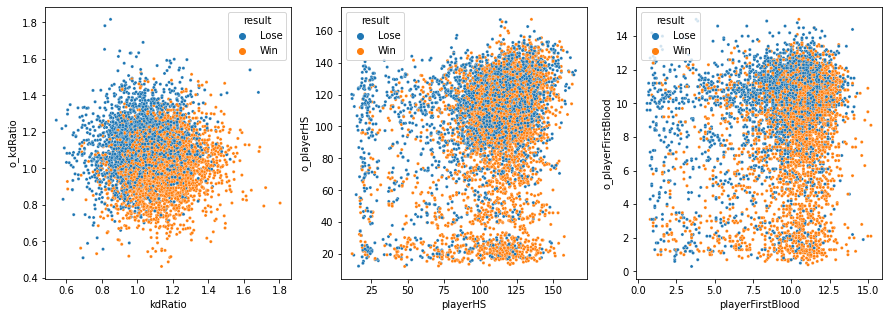

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(data=data, x='kdRatio', y='o_kdRatio', hue='result', ax=ax1, s=10)
sns.scatterplot(data=data, x='playerHS', y='o_playerHS', hue='result', ax=ax2, s=10)
sns.scatterplot(data=data, x='playerFirstBlood', y='o_playerFirstBlood', hue='result', ax=ax3, s=10)

In [35]:
data.columns

Index(['Unnamed: 0', 'map', 'o_playerACS', 'o_playerADR', 'o_playerAssists',
       'o_playerDeaths', 'o_playerFirstBlood', 'o_playerFirstDeath',
       'o_playerHS', 'o_playerKills', 'o_playerTeam', 'playerACS', 'playerADR',
       'playerAssists', 'playerDeaths', 'playerFirstBlood', 'playerFirstDeath',
       'playerHS', 'playerKills', 'playerTeam', 'result', 'kdRatio',
       'o_kdRatio'],
      dtype='object')

In [50]:
otherData = pd.read_csv('cleanedData.csv').dropna().drop('Unnamed: 0', axis=1)
otherData['playerHS'] = otherData['playerHS'].apply(lambda x: float(x.split('%')[0]))
otherData

,playerName,playerTeam,map,playerAgent,playerKills,playerDeaths,playerAssists,playerACS,playerADR,playerHS,...,playerFirstDeath,matchID,gameID,opponent,result,winnerRoundsWon,loserRoundsWon,winningTeam,date,event
0,stax,VS,Haven,breach,22.0,11.0,5.0,262.0,157.0,53.0,...,2.0,VSvsFS01-12-21,VSvsFS01-12-21Haven,FS,Win,13,5,VS,01-12-21,VALORANT Champions
1,Rb,VS,Haven,skye,13.0,10.0,7.0,212.0,158.0,33.0,...,2.0,VSvsFS01-12-21,VSvsFS01-12-21Haven,FS,Win,13,5,VS,01-12-21,VALORANT Champions
2,k1Ng,VS,Haven,killjoy,13.0,13.0,3.0,212.0,158.0,24.0,...,2.0,VSvsFS01-12-21,VSvsFS01-12-21Haven,FS,Win,13,5,VS,01-12-21,VALORANT Champions
3,MaKo,VS,Haven,astra,13.0,8.0,6.0,209.0,154.0,24.0,...,1.0,VSvsFS01-12-21,VSvsFS01-12-21Haven,FS,Win,13,5,VS,01-12-21,VALORANT Champions
4,BuZz,VS,Haven,jett,14.0,12.0,6.0,206.0,152.0,38.0,...,1.0,VSvsFS01-12-21,VSvsFS01-12-21Haven,FS,Win,13,5,VS,01-12-21,VALORANT Champions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138035,SepiaMars,INSM,Bind,omen,6.0,13.0,3.0,150.0,90.0,27.0,...,0.0,ZETAvsINSM11-08-21,ZETAvsINSM11-08-21Bind,ZETA,Lose,13,1,ZETA,11-08-21,Champions Tour Japan Stage 3: Challengers Play...
138036,K1llgrave,INSM,Bind,sage,5.0,13.0,1.0,137.0,85.0,20.0,...,3.0,ZETAvsINSM11-08-21,ZETAvsINSM11-08-21Bind,ZETA,Lose,13,1,ZETA,11-08-21,Champions Tour Japan Stage 3: Challengers Play...
138037,something,INSM,Bind,reyna,6.0,15.0,0.0,136.0,78.0,46.0,...,2.0,ZETAvsINSM11-08-21,ZETAvsINSM11-08-21Bind,ZETA,Lose,13,1,ZETA,11-08-21,Champions Tour Japan Stage 3: Challengers Play...
138038,nagi,INSM,Bind,jett,5.0,14.0,2.0,124.0,67.0,13.0,...,1.0,ZETAvsINSM11-08-21,ZETAvsINSM11-08-21Bind,ZETA,Lose,13,1,ZETA,11-08-21,Champions Tour Japan Stage 3: Challengers Play...
